In [10]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

RESULTS = Path("results")

oracle_path = RESULTS / "oracle_ari.csv"
automl_path = RESULTS / "automl_results.csv"
cvi_path = RESULTS / "cvi_results.csv"
deep_path = RESULTS / "DAPINet_results.csv"

oracle_df = pd.read_csv(oracle_path)
automl_df = pd.read_csv(automl_path)
cvi_df = pd.read_csv(cvi_path)
deep_df = pd.read_csv(deep_path)

In [2]:
def _oracle_long_table(oracle_wide: pd.DataFrame) -> pd.DataFrame:
    if "dataset" not in oracle_wide.columns:
        raise ValueError("Expected oracle table to contain a dataset column")

    value_columns = [c for c in oracle_wide.columns if c != "dataset"]
    oracle_long = oracle_wide.melt(
        id_vars=["dataset"],
        value_vars=value_columns,
        var_name="algorithm",
        value_name="oracle_ari",
    )
    return oracle_long


def _map_selected_algorithm_to_oracle_ari(
    *,
    dataset_to_algorithm: pd.DataFrame,
    algorithm_col: str,
    method_name: str,
    oracle_long: pd.DataFrame,
) -> pd.DataFrame:
    required = {"dataset", algorithm_col}
    missing = required - set(dataset_to_algorithm.columns)
    if missing:
        raise ValueError(f"Missing required columns for {method_name}: {sorted(missing)}")

    tmp = dataset_to_algorithm[["dataset", algorithm_col]].copy()
    tmp = tmp.rename(columns={algorithm_col: "algorithm"})

    mapped = tmp.merge(oracle_long, on=["dataset", "algorithm"], how="left")
    mapped = mapped.rename(
        columns={
            "algorithm": f"{method_name}_algorithm",
            "oracle_ari": f"{method_name}_oracle_ari",
        }
    )
    return mapped


oracle_long = _oracle_long_table(oracle_df)
oracle_wide = oracle_df.set_index("dataset")
oracle_best_algorithm = oracle_wide.idxmax(axis=1)
oracle_best_ari = oracle_wide.max(axis=1)

oracle_best = pd.DataFrame(
    {
        "dataset": oracle_best_algorithm.index,
        "oracle_best_algorithm": oracle_best_algorithm.values,
        "oracle_best_ari": oracle_best_ari.values,
    }
).set_index("dataset")

# --- Collect method outputs (algorithm selection) ---
method_tables: list[pd.DataFrame] = []

# CVIs: algorithm columns end with _algorithm
for col in [c for c in cvi_df.columns if c.endswith("_algorithm")]:
    method_name = col.removesuffix("_algorithm")
    method_tables.append(
        _map_selected_algorithm_to_oracle_ari(
            dataset_to_algorithm=cvi_df,
            algorithm_col=col,
            method_name=method_name,
            oracle_long=oracle_long,
        ).set_index("dataset")
    )

# AutoML baselines: algorithm columns end with _algorithm
for col in [c for c in automl_df.columns if c.endswith("_algorithm")]:
    method_name = col.removesuffix("_algorithm")
    method_tables.append(
        _map_selected_algorithm_to_oracle_ari(
            dataset_to_algorithm=automl_df,
            algorithm_col=col,
            method_name=method_name,
            oracle_long=oracle_long,
        ).set_index("dataset")
    )

# Deep model selection (column is not *_algorithm, but it is the selected algorithm)
method_tables.append(
    _map_selected_algorithm_to_oracle_ari(
        dataset_to_algorithm=deep_df,
        algorithm_col="selected_algorithm",
        method_name="DeepModel",
        oracle_long=oracle_long,
    ).set_index("dataset")
)

# Merge all per-method tables into one wide table
per_dataset = oracle_best.copy()
for t in method_tables:
    per_dataset = per_dataset.join(t, how="left")

# Order methods by descending mean oracle-ARI (computed on dataset rows only)
oracle_ari_cols = [c for c in per_dataset.columns if c.endswith("_oracle_ari")]
mean_by_method = per_dataset[oracle_ari_cols].mean(axis=0, skipna=True).sort_values(ascending=False)

ordered_methods = [c.removesuffix("_oracle_ari") for c in mean_by_method.index]
ordered_method_columns: list[str] = []
for m in ordered_methods:
    ordered_method_columns.extend([f"{m}_algorithm", f"{m}_oracle_ari"])

# Assemble final per-dataset table: methods first, then oracle-wide columns last
final_dataset_table = per_dataset[
    ["oracle_best_algorithm", "oracle_best_ari"] + ordered_method_columns
].copy()

In [3]:
# --- Add requested summary rows ---
dataset_rows = final_dataset_table.copy()
pred_ari_cols = [c for c in dataset_rows.columns if c.endswith("_oracle_ari")]
pred_alg_cols = [c for c in dataset_rows.columns if c.endswith("_algorithm")]

oracle_best_vec = dataset_rows["oracle_best_ari"].astype(float)

summary = pd.DataFrame(
    index=[
        "mean",
        "median",
        "mse",
        "mean_regret",
        "median_regret",
        "exact_best_count",
        "within_10pct_of_oracle_best_count",
    ]
)

# Fill non-method columns with blanks
summary["oracle_best_algorithm"] = ""
summary["oracle_best_ari"] = [
    np.mean(oracle_best_vec),
    np.median(oracle_best_vec),
    np.nan,  # mse
    np.nan,  # mean_regret
    np.nan,  # median_regret
    np.nan,  # exact_best_count
    np.nan,  # within_10pct_of_oracle_best_count
]

# Algorithm columns: blank for summary rows
for c in pred_alg_cols:
    summary[c] = ""

# Metric rows for each method's oracle-ARI
for c in pred_ari_cols:
    pred = dataset_rows[c].astype(float)
    summary.loc["mean", c] = float(pred.mean(skipna=True))
    summary.loc["median", c] = float(pred.median(skipna=True))

    # MSE vs oracle-best ARI
    diff = pred - oracle_best_vec
    summary.loc["mse", c] = float((diff * diff).mean(skipna=True))

    # Regret (Oracle Best - Pred)
    regret = oracle_best_vec - pred
    summary.loc["mean_regret", c] = float(regret.mean(skipna=True))
    summary.loc["median_regret", c] = float(regret.median(skipna=True))

    # Exact oracle-best algorithm count
    alg_col = c.removesuffix("_oracle_ari") + "_algorithm"
    pred_alg = dataset_rows[alg_col].astype(str)
    summary.loc["exact_best_count", c] = int(
        (pred_alg == dataset_rows["oracle_best_algorithm"].astype(str)).sum()
    )

    # Within 10% of oracle-best (relative)
    within = pred >= (oracle_best_vec - 0.1)
    summary.loc["within_10pct_of_oracle_best_count", c] = int(within.sum())


final_table = pd.concat([dataset_rows, summary], axis=0)
# Make dataset a real column for easier export
final_table = final_table.reset_index(names="dataset")
final_table.tail(10)

,dataset,oracle_best_algorithm,oracle_best_ari,DeepModel_algorithm,DeepModel_oracle_ari,ML2DAC_statistical+info-theory+general_algorithm,ML2DAC_statistical+info-theory+general_oracle_ari,AML4C_DBCV_algorithm,AML4C_DBCV_oracle_ari,AML4C_COP_algorithm,...,AutoClust_algorithm,AutoClust_oracle_ari,davies_bouldin_algorithm,davies_bouldin_oracle_ari,calinski_harabasz_algorithm,calinski_harabasz_oracle_ari,silhouette_algorithm,silhouette_oracle_ari,dunn_algorithm,dunn_oracle_ari
17,Wine,spectral_clustering,0.947132,spectral_clustering,0.947132,k-means,0.897495,gaussian,0.897495,birch,...,dbscan,0.436186,optics,0.733018,optics,0.733018,optics,0.733018,optics,0.733018
18,WineQualityRed,birch,0.091496,birch,0.091496,gaussian,0.084203,k-means,0.062733,ward,...,dbscan,0.025044,hdbscan,0.021896,k-means,0.062733,hdbscan,0.021896,hdbscan,0.021896
19,Yeast,spectral_clustering,0.239494,spectral_clustering,0.239494,ward,0.198692,ward,0.198692,ward,...,mean_shift,0.173497,hdbscan,0.011632,k-means,0.165367,hdbscan,0.011632,hdbscan,0.011632
20,mean,,0.401598,,0.352790,,0.254237,,0.249442,,...,,0.229423,,0.218381,,0.210940,,0.187779,,0.186958
21,median,,0.345239,,0.245972,,0.193067,,0.193067,,...,,0.178457,,0.141387,,0.173576,,0.114494,,0.118255
22,mse,,NaN,,0.011488,,0.047214,,0.049062,,...,,0.056525,,0.062743,,0.060949,,0.072171,,0.066835
23,mean_regret,,NaN,,0.048809,,0.147362,,0.152156,,...,,0.172175,,0.183217,,0.190658,,0.213820,,0.214640
24,median_regret,,NaN,,0.005170,,0.075806,,0.085912,,...,,0.095658,,0.128579,,0.143105,,0.220988,,0.220988
25,exact_best_count,,NaN,,10.000000,,0.000000,,0.000000,,...,,1.000000,,0.000000,,0.000000,,1.000000,,0.000000
26,within_10pct_of_oracle_best_count,,NaN,,18.000000,,12.000000,,12.000000,,...,,11.000000,,9.000000,,8.000000,,7.000000,,6.000000


In [4]:
# Optional: export the resulting table
out_path = RESULTS / "method_oracle_mapped_table.csv"
final_table.to_csv(out_path, index=False)
out_path

WindowsPath('results/method_oracle_mapped_table.csv')

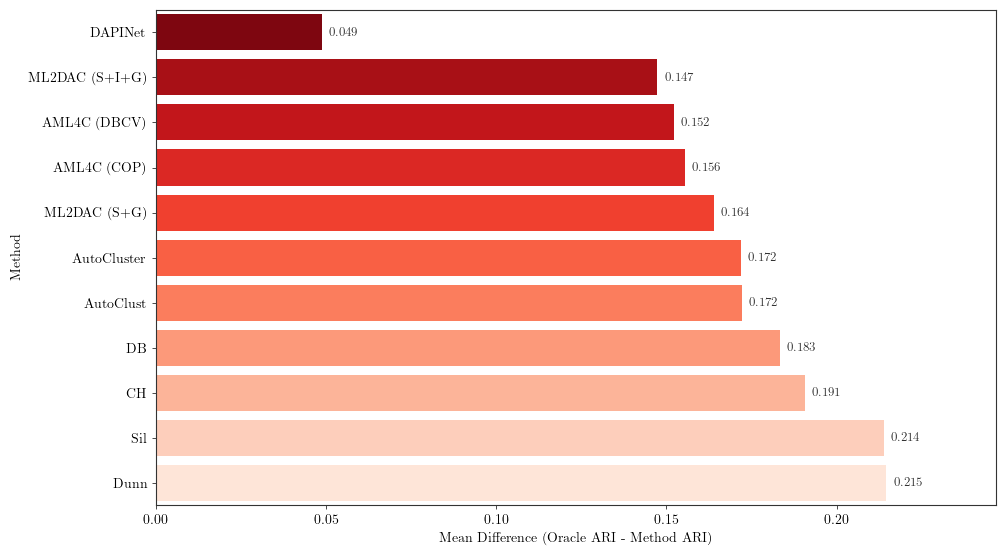

In [13]:
# Gap Analysis to Oracle (Regret Chart) - Professional Style with Box Frame

# Use Type 1 fonts (Computer Modern / Times-like)
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)
# Extract only the 20 dataset rows (exclude summary rows)
dataset_only = final_table[
    ~final_table["dataset"].isin(
        [
            "mean",
            "median",
            "mse",
            "mean_regret",
            "median_regret",
            "exact_best_count",
            "within_10pct_of_oracle_best_count",
        ]
    )
].copy()
# Get oracle ARI and method ARI columns
oracle_ari = dataset_only["oracle_best_ari"].astype(float).values
# Find all method oracle_ari columns (excluding oracle_best_ari)
method_ari_cols = [
    c for c in dataset_only.columns if c.endswith("_oracle_ari") and c != "oracle_best_ari"
]
# Calculate mean gap (regret) for each method
gaps = {}
for col in method_ari_cols:
    method_name = col.removesuffix("_oracle_ari")
    if method_name in ["AutoCluster_DBI", "AutoCluster_SIL"]:
        continue
    method_ari = dataset_only[col].astype(float).values
    gap = np.nanmean(oracle_ari - method_ari)
    gaps[method_name] = gap
# Create short names mapping
short_names = {
    "DeepModel": "DAPINet",
    "ML2DAC_statistical+info-theory+general": "ML2DAC (S+I+G)",
    "AML4C_DBCV": "AML4C (DBCV)",
    "AML4C_COP": "AML4C (COP)",
    "ML2DAC_statistical+general": "ML2DAC (S+G)",
    "AutoCluster_CH": "AutoCluster",
    "AutoClust": "AutoClust",
    "davies_bouldin": "DB",
    "calinski_harabasz": "CH",
    "silhouette": "Sil",
    "dunn": "Dunn",
}
# Apply short names and sort by gap (ascending = best first)
gaps_renamed = {short_names.get(k, k): v for k, v in gaps.items()}
gaps_sorted = dict(sorted(gaps_renamed.items(), key=lambda x: x[1]))
methods = list(gaps_sorted.keys())
gap_values = list(gaps_sorted.values())
# Create color gradient (dark red to light pink/peach)
n = len(methods)
colors = plt.cm.Reds(np.linspace(0.95, 0.1, n))

plt.rcParams.update(
    {
        "pdf.use14corefonts": True,  # Type 1 fonts for ICML
        "ps.useafm": True,
    }
)

# Create the horizontal bar chart with tight layout
fig, ax = plt.subplots(figsize=(10, 5.5))
y_pos = np.arange(len(methods))
bar_height = 0.8
bars = ax.barh(y_pos, gap_values, height=bar_height, color=colors, edgecolor="none")
# Add gap values on the right side of each bar
max_gap = max(gap_values)
for i, (bar, val) in enumerate(zip(bars, gap_values)):
    ax.text(
        val + max_gap * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.3f}",
        va="center",
        ha="left",
        fontsize=9,
        color="#333333",
    )
ax.set_yticks(y_pos)
ax.set_yticklabels(methods)
ax.invert_yaxis()  # Best (lowest gap) at top
ax.set_xlabel("Mean Difference (Oracle ARI - Method ARI)")
ax.set_ylabel("Method")
# ax.set_title('Average Performance Gap to Oracle (Regret)')
# Keep all spines visible for box frame
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("#333333")
ax.tick_params(axis="both", which="both", length=3, width=0.5)

ax.set_ylim(len(methods) - 0.5, -0.5)
ax.set_xlim(0, max(gap_values) * 1.15)

# Extend x-axis to accommodate text labels
plt.tight_layout(pad=0.5)
plt.savefig("results/figures/gap_analysis_to_oracle.pdf", dpi=600)
plt.show()

In [17]:
# Wilcoxon signed-rank test: DeepModel vs all others
# deep_col = "DeepModel_oracle_ari"
# deep_model_scores = method_ari_cols[deep_col]
results = []

# 3. Identify the DeepModel (DAPINet) score column
deep_model_col = "DeepModel_oracle_ari"
deep_model_scores = dataset_only[deep_model_col]

# 4. Iterate over other methods to perform the test
for key, mapped_name in short_names.items():
    # Skip comparing DeepModel to itself
    if key == "DeepModel":
        continue

    # Construct the column name for the competing method
    col_name = key + "_oracle_ari"

    if col_name in dataset_only.columns:
        other_scores = dataset_only[col_name]

        try:
            # Perform Wilcoxon signed-rank test
            # stats.wilcoxon tests the null hypothesis that two related paired samples
            # come from the same distribution.
            stat, p_value = wilcoxon(deep_model_scores, other_scores)

            # Calculate Mean Difference to determine direction (positive = DeepModel is better)
            diff = deep_model_scores - other_scores
            mean_diff = diff.mean()

            results.append(
                {
                    "Method": mapped_name,
                    "Comparison": f"DAPINet vs {mapped_name}",
                    "W-statistic": stat,
                    "p-value": p_value,
                    "Mean Difference": mean_diff,
                }
            )
        except ValueError as e:
            # This catches cases where the difference is zero for all samples
            results.append(
                {
                    "Method": mapped_name,
                    "Comparison": f"DAPINet vs {mapped_name}",
                    "W-statistic": "N/A",
                    "p-value": 1.0,
                    "Mean Difference": 0.0,
                }
            )

# 5. Create a DataFrame to display results
results_df = pd.DataFrame(results)

# Optional: Format the display for cleaner reading
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print(results_df)
print("DAPINet shows a statistically significant improvement over all compared methods")
print("(all p-values < 0.01) based on the Wilcoxon signed-rank test on the provided dataset.")

           Method                 Comparison  W-statistic   p-value  Mean Difference
0  ML2DAC (S+I+G)  DAPINet vs ML2DAC (S+I+G)         22.0  0.001017         0.098553
1    AML4C (DBCV)    DAPINet vs AML4C (DBCV)         11.0  0.000105         0.103348
2     AML4C (COP)     DAPINet vs AML4C (COP)         30.0  0.003654         0.106701
3    ML2DAC (S+G)    DAPINet vs ML2DAC (S+G)         21.0  0.000851         0.115031
4     AutoCluster     DAPINet vs AutoCluster         16.0  0.001477         0.123014
5       AutoClust       DAPINet vs AutoClust         23.0  0.006491         0.123366
6              DB              DAPINet vs DB         33.0  0.005581         0.134408
7              CH              DAPINet vs CH          3.0  0.000214         0.141850
8             Sil             DAPINet vs Sil          7.0  0.000398         0.165011
9            Dunn            DAPINet vs Dunn         10.0  0.000625         0.165831
DAPINet shows a statistically significant improvement over all co

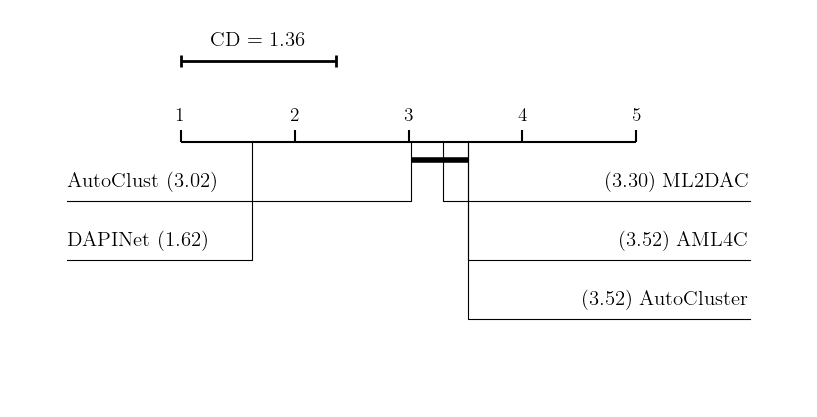

In [18]:
def plot_cd_diagram(avg_ranks, cd, labels, filename="cd_diagram.png"):
    """
    Plots a Critical Difference diagram based on Demšar (2006).
    """
    # Sort ranks and labels
    sorted_idx = np.argsort(avg_ranks)
    avg_ranks = avg_ranks[sorted_idx]
    labels = np.array(labels)[sorted_idx]
    k = len(labels)
    # Figure setup - narrower and shorter
    plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Computer Modern Roman"],
            "pdf.fonttype": 42,
            "ps.fonttype": 42,
        }
    )
    fig, ax = plt.subplots(figsize=(8, 4))  # Narrower figure
    ax.set_xlim(-0.5, k + 1.5)

    # Calculate y limits based on number of methods
    mid = (k + 1) / 2
    left_count = len([r for r in avg_ranks if r <= mid])
    right_count = len([r for r in avg_ranks if r > mid])
    max_count = max(left_count, right_count)
    y_step = 0.4
    y_min = -(max_count + 0.5) * y_step
    ax.set_ylim(y_min, 0.9)  # Tighter y limits

    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    # Draw main scale
    ax.hlines(0, 1, k, colors="black", linewidth=1.5)
    for i in range(1, k + 1):
        ax.vlines(i, 0, 0.08, colors="black", linewidth=1.5)
        ax.text(i, 0.12, str(i), ha="center", va="bottom", fontsize=14, fontweight="bold")
    # CD bar - close to rank line
    cd_x, cd_y = 1, 0.55
    ax.hlines(cd_y, cd_x, cd_x + cd, colors="black", linewidth=2)
    ax.vlines([cd_x, cd_x + cd], cd_y - 0.04, cd_y + 0.04, colors="black", linewidth=2)
    ax.text(cd_x + cd / 2, cd_y + 0.08, f"CD = {cd:.2f}", ha="center", va="bottom", fontsize=15)
    # Plot method labels and connecting lines
    mid = (k + 1) / 2
    # Left side (Rank 1 to Mid) - labels aligned at left edge
    left_idx = [i for i, r in enumerate(avg_ranks) if r <= mid + 0.2]
    for i, idx in enumerate(left_idx[::-1]):
        rank, label = avg_ranks[idx], labels[idx]
        y_pos = -(i + 1) * y_step
        ax.plot([rank, rank, 0], [0, y_pos, y_pos], color="black", linewidth=0.8)
        # All labels aligned at x=0, left-aligned
        ax.text(0, y_pos + 0.06, f"{label} ({rank:.2f})", ha="left", va="bottom", fontsize=15)
    # Right side (Mid to K) - labels aligned at right edge
    right_idx = [i for i, r in enumerate(avg_ranks) if r > mid + 0.2]
    for i, idx in enumerate(right_idx):
        rank, label = avg_ranks[idx], labels[idx]
        y_pos = -(i + 1) * y_step
        ax.plot([rank, rank, k + 1], [0, y_pos, y_pos], color="black", linewidth=0.8)
        # All labels aligned at x=k+1, right-aligned
        ax.text(k + 1, y_pos + 0.06, f"({rank:.2f}) {label}", ha="right", va="bottom", fontsize=15)
    # Calculate and draw cliques (non-significant groups)
    groups = []
    for i in range(k):
        for j in range(i + 1, k):
            if avg_ranks[j] - avg_ranks[i] <= cd:
                groups.append((i, j))
    # Filter for maximal cliques
    maximal_groups = []
    for g1 in groups:
        if not any((g1 != g2 and g1[0] >= g2[0] and g1[1] <= g2[1]) for g2 in groups):
            if g1 not in maximal_groups:
                maximal_groups.append(g1)
    y_base, y_group_step = -0.12, 0.1
    for i, (start_idx, end_idx) in enumerate(maximal_groups):
        y = y_base - i * y_group_step
        ax.hlines(y, avg_ranks[start_idx], avg_ranks[end_idx], colors="black", linewidth=4)
    plt.tight_layout(pad=0.1)
    plt.savefig(filename, dpi=600, bbox_inches="tight", pad_inches=0.05)
    plt.show()


# 2. Mapping for clean labels
name_mapping = {
    "DeepModel_oracle_ari": "DAPINet",
    "ML2DAC_statistical+info-theory+general_oracle_ari": "ML2DAC",
    "AML4C_DBCV_oracle_ari": "AML4C",
    "AML4C_COP_oracle_ari": "AML4C (COP)",
    "ML2DAC_statistical+general_oracle_ari": "ML2DAC (S+G)",
    "AutoCluster_CH_oracle_ari": "AutoCluster",
    "AutoClust_oracle_ari": "AutoClust",
    "davies_bouldin_oracle_ari": "DB",
    "calinski_harabasz_oracle_ari": "CH",
    "silhouette_oracle_ari": "Silhouette",
    "dunn_oracle_ari": "Dunn",
}

# Remove duplicated methods and cvis from the comparison
exclude_methods = {
    "AML4C_COP_oracle_ari",
    "AutoCluster_DBI_oracle_ari",
    "AutoCluster_SIL_oracle_ari",
    "ML2DAC_statistical+general_oracle_ari",
    "davies_bouldin_oracle_ari",
    "calinski_harabasz_oracle_ari",
    "silhouette_oracle_ari",
    "dunn_oracle_ari"

}
method_ari_cols = [m for m in method_ari_cols if m not in exclude_methods]

data = dataset_only[method_ari_cols].rename(columns=name_mapping)

# 3. Calculate Ranks and CD
ranks = data.rank(axis=1, ascending=False)
avg_ranks = ranks.mean().sort_values()
k, n = len(avg_ranks), len(dataset_only)

# Nemenyi critical value for alpha=0.05
# Updated q_alpha for k=7 is approximately 3.014 (if applicable)
# Keeping the structure for CD calculation
q_alpha = 2.728
cd = q_alpha * np.sqrt((k * (k + 1)) / (6 * n))

# 4. Generate Plot
plot_cd_diagram(avg_ranks.values, cd, avg_ranks.index.tolist(), "results/figures/cd_diagram.pdf")

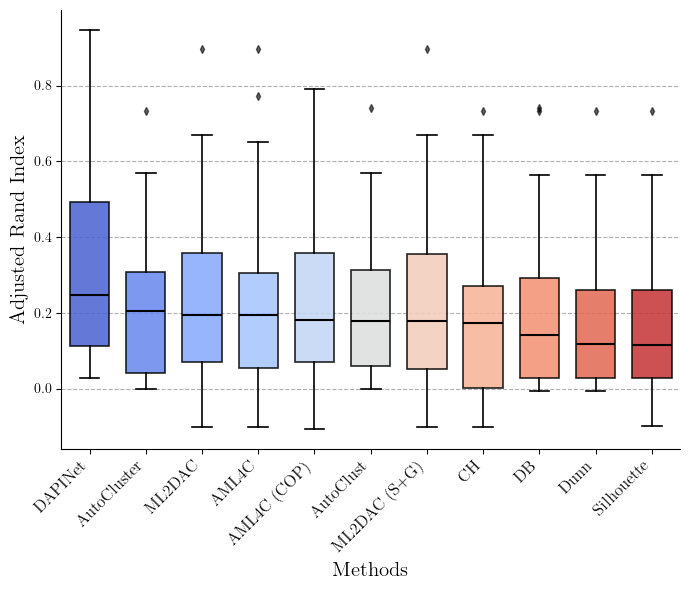

In [19]:
# Use only per-dataset rows and method oracle-ARI columns
scores = dataset_rows[pred_ari_cols].astype(float).copy()

# Order methods by mean ARI (best on top)
order_cols = scores.median(axis=0, skipna=True).sort_values(ascending=False).index.tolist()
# Filter out AutoCluster_DBI and AutoCluster_SIL
order_cols = [
    c for c in order_cols if c not in ["AutoCluster_DBI_oracle_ari", "AutoCluster_SIL_oracle_ari"]
]
method_labels = [name_mapping.get(c, c) for c in order_cols]

data = [scores[c].dropna().values for c in order_cols]
k = len(order_cols)

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)
# Colormap: low index = blue, high index = red
cmap = plt.get_cmap("coolwarm")
colors = [cmap(x) for x in np.linspace(0.05, 0.95, k)]

fig, ax = plt.subplots(figsize=(7, 6))


bp = ax.boxplot(
    data,
    vert=True,  # Changed from False to True
    tick_labels=method_labels,
    patch_artist=True,
    showfliers=True,
    widths=0.7,
    medianprops=dict(color="black", linewidth=1.5),
    boxprops=dict(linewidth=1.2),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(
        marker="d", markersize=4, markerfacecolor="black", markeredgecolor="black", alpha=0.6
    ),
)

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.85)

# Best method on top (like your reference figure)
plt.xticks(rotation=45, ha="right", fontsize=12)

ax.set_xlabel("Methods", fontsize=15)
ax.set_ylabel("Adjusted Rand Index", fontsize=15)
ax.grid(True, axis="y", linestyle="--")  # Change from "x" to "y"

# Paper-like cleanup
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
plt.savefig("results/figures/boxplot_comparison.pdf", dpi=600, bbox_inches="tight")
plt.tight_layout()
plt.show()

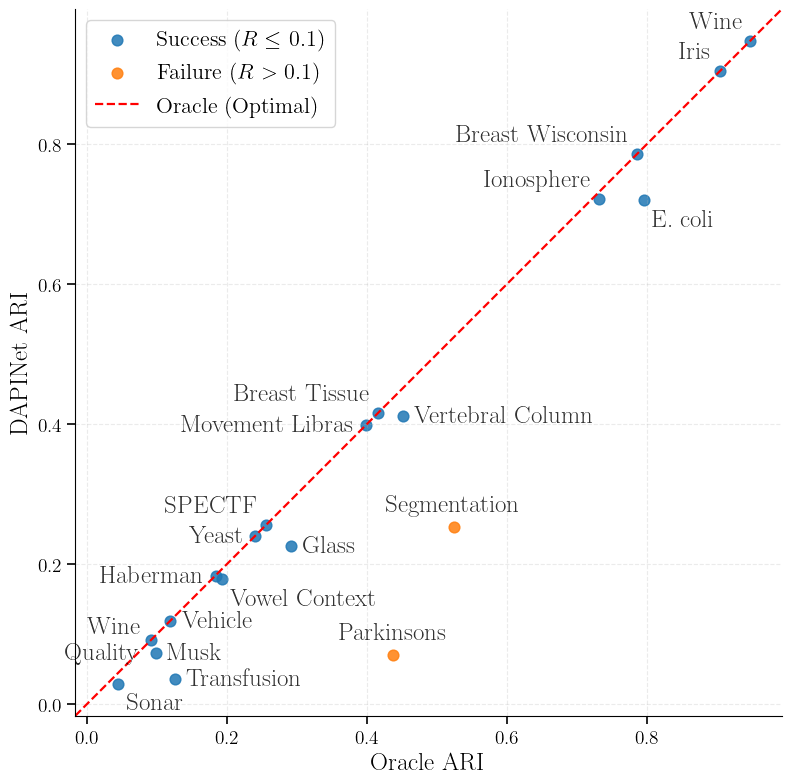

In [20]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)
scatter_df = dataset_rows.reset_index()[
    ["dataset", "oracle_best_ari", "DeepModel_oracle_ari"]
].copy()
scatter_df[["oracle_best_ari", "DeepModel_oracle_ari"]] = scatter_df[
    ["oracle_best_ari", "DeepModel_oracle_ari"]
].astype(float)
scatter_df = scatter_df.dropna(subset=["oracle_best_ari", "DeepModel_oracle_ari"]).copy()

x = scatter_df["oracle_best_ari"].to_numpy(dtype=float)
y = scatter_df["DeepModel_oracle_ari"].to_numpy(dtype=float)

# Define success as within 10% of oracle-best (relative).
success = y >= (x - 0.1)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x[success], y[success], s=60, alpha=0.85, label=r"Success ($R \leq$ 0.1)")
ax.scatter(x[~success], y[~success], s=60, alpha=0.85, label=r"Failure ($R > 0.1$)")

# y=x reference (oracle optimal line)
lo = float(np.nanmin(np.r_[x, y])) if len(x) else 0.0
hi = float(np.nanmax(np.r_[x, y])) if len(x) else 1.0
pad = 0.05 * (hi - lo if hi > lo else 1.0)
lo, hi = lo - pad, hi + pad
ax.plot([lo, hi], [lo, hi], "r--", linewidth=1.6, label="Oracle (Optimal)")

# Annotate each point with smarter, geometry-aware offsets
manual_positions = {
    "Ionosphere": "top left",
    "Breast Tissue": "top left",
    "Breast Wisconsin": "top left",
    "Vertebral Column": "right",
    "SPECTF": "top left",
    "Yeast": "left",
    "Movement Libras": "left",
    "Wine Quality": "left",
    "Musk": "right",
    "Haberman": "left",
    "Vowel Context": "bottom right",
    "Transfusion": "right",
    "Vehicle": "right",
    "Glass": "right",
    "Sonar": "bottom right",
    "Iris": "top left",
    "Wine": "top left",
    "E. coli": "bottom right",
    "Wine \n Quality": "left"
}

DATASET_NAME_MAP = {
    "BreastTissue": "Breast Tissue",
    "BreastWisconsin": "Breast Wisconsin",
    "Ecoli": "E. coli",
    "Glass": "Glass",
    "Haberman": "Haberman",
    "Ionosphere": "Ionosphere",
    "Iris": "Iris",
    "Movement_libras": "Movement Libras",
    "Musk": "Musk",
    "Parkinsons": "Parkinsons",
    "Segmentation": "Segmentation",
    "SonarAll": "Sonar",
    "Spectf": "SPECTF",
    "Transfusion": "Transfusion",
    "Vehicle": "Vehicle",
    "VertebralColumn": "Vertebral Column",
    "Vowel_context": "Vowel Context",
    "Wine": "Wine",
    "WineQualityRed": "Wine \n Quality",
    "Yeast": "Yeast",
}

x_med = np.median(x)
y_med = np.median(y)


for _, row in scatter_df.iterrows():
    raw_name = str(row["dataset"])
    name = DATASET_NAME_MAP.get(raw_name, raw_name)
    x0 = float(row["oracle_best_ari"])
    y0 = float(row["DeepModel_oracle_ari"])

    # --- Choose direction ---
    direction = manual_positions.get(name, "top")

    # --- Convert direction to offsets ---
    if direction == "left":
        off_x, off_y = -8, 0
        ha, va = "right", "center"
    elif direction == "right":
        off_x, off_y = 8, 0
        ha, va = "left", "center"
    elif direction == "bottom":
        off_x, off_y = 0, -8
        ha, va = "center", "top"
    elif direction == "top left":
        off_x, off_y = -6, 6
        ha, va = "right", "bottom"
    elif direction == "bottom right":
        off_x, off_y = 6, -6
        ha, va = "left", "top"
    else:  # "top"
        off_x, off_y = 0, 8
        ha, va = "center", "bottom"

    ax.annotate(
        name,
        (x0, y0),
        textcoords="offset points",
        xytext=(off_x, off_y),
        ha=ha,
        va=va,
        fontsize=18,
        alpha=0.8,
    )

ax.set_xlabel("Oracle ARI", fontsize=18)
ax.set_ylabel("DAPINet ARI", fontsize=18)
ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)
ax.set_aspect("equal", adjustable="box")
ax.grid(True, linestyle="--", alpha=0.25)

# Paper-like cleanup
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Refactoring: increase tick label size and tick marker size
ax.tick_params(axis="both", which="major", labelsize=14, length=6, width=1.2)

ax.legend(loc="upper left", fontsize=16)
plt.tight_layout()
plt.savefig("results/figures/oracle_dl_comparison.pdf", dpi=600, bbox_inches="tight")
plt.show()